In [5]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from itertools import combinations
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Tissue Clustering

Author: John Vivian

When pairing GTEx and TCGA, some of the tissue pairing is apparent (e.g. **stomach** from GTEx and **stomach adenocarcinoma** from TCGA), but a lot of it is not as straight forward, so let's take a look.

Information pertaining to reproducing these plots is located at the bottom. A separate `.py` file is being written that will generate these plots given the project structure.

#### Convenience functions

In [4]:
def create_classification_vector(df_paths):
    vector, label = [], []
    for i, f in enumerate(df_paths):
        name = os.path.basename(f.split('.tsv')[0])
        with open(f, 'r') as f:
            line = f.readline().strip().split('\t')
            vector.extend([x for x in line])
            label.extend([i for _ in line])
    return vector, np.array(label)

def create_combined_df(df_paths, pc_genes):
    dfs = [pd.read_csv(x, sep='\t', index_col=0) for x in df_paths]
    df = pd.concat(dfs, axis=1)
    df = remove_nonprotein_coding_genes(df, pc_genes)
    return df.T

def find_protein_coding_genes(gencode_path):
    pc_genes = set()
    with open(gencode_path, 'r') as f:
        for line in f.readlines():
            if not line.startswith('#'):
                line = line.split()
                if line[line.index('gene_type') + 1] == '"protein_coding";':
                    pc_genes.add(line[line.index('gene_id') + 1].split('"')[1])
    return list(pc_genes)

def remove_nonprotein_coding_genes(df, pc_genes):
    return df.ix[pc_genes]
    
def run_PCA(df):
    pca = PCA(n_components=2)
    return pca.fit(df).transform(df)

def run_TSNE(df):
    model = TSNE(n_components=2)
    return model.fit_transform(np.array(df)) 

def plot_dimensionality_reduction(X, files, label, alpha=0.5, bbox=(1.75, 1)):
    cm = plt.get_cmap('Accent')
    color_set = (cm(1.*i/len(files)) for i in xrange(len(files)))
    names = [os.path.basename(x).split('.tsv')[0] for x in files]
    length = [x for x in xrange(len(files))]
    for color, i, target_name in zip(color_set, length, names):
        plt.scatter(X[label == i, 0], X[label == i, 1], alpha=alpha, color=color, label=target_name)
    plt.legend(bbox_to_anchor=bbox);

def determine_distance(X, label, files):
    smallest_distance = sys.maxint
    for a, b in combinations(set(label), 2):
        dist = np.sqrt((X[label==a,0].mean() - X[label==b,0].mean())**2 + 
                       (X[label==a,1].mean() - X[label==b,1].mean())**2)
        s1 = os.path.basename(files[a]).split('.tsv')[0]
        s2 = os.path.basename(files[b]).split('.tsv')[0]
        if 'tumor' in s1 or 'tumor' in s2:
            print 'Distance for: {} {}: {} '.format(s1, s2, dist)
            if dist < smallest_distance:
                smallest_set = (s1, s2)
                smallest_distance = dist
    print '\nSmallest Distance: ' + ', '.join(smallest_set) + ': ' + str(smallest_distance)
    
def remove_outliers(X, label, vector, files, percentile=98, alpha=0.5):
    # Create outlier mask
    outlier_mask = (X[:,0] < np.percentile(X[:,0], percentile)) & (X[:,1] < np.percentile(X[:,1], percentile))
    # Refit / transform with the mask applied
    X_mask = run_TSNE(X[outlier_mask])
    # Apply mask to labels
    label_mask = label[outlier_mask]
    plot_dimensionality_reduction(X_mask, files, label_mask, alpha=alpha)
    return X_mask, label_mask, set(vector) - set(np.array(vector)[outlier_mask])

def split_TCGA_tumor_normal(directory):
    files = [os.path.join(directory, x) for x in os.listdir(directory) 
             if not x.endswith('normal.tsv') and not x.endswith('tumor.tsv')]
    tcga_dfs = []
    for f in files:
        with open(f, 'r') as f_out:
            line = f_out.readline().strip().split('\t')
            if all('TCGA-' in x for x in line):
                tcga_dfs.append(f)
    # Create df splits
    for f in tcga_dfs:
        df = pd.read_csv(f, sep='\t', index_col=0)
        tumor = [x for x in df.columns if x.endswith('-01')]
        normal = [x for x in df.columns if x.endswith('-11')]
        if normal:
            df[normal].to_csv(f[:-4] + '_normal.tsv', sep='\t')
        df[tumor].to_csv(f[:-4] + '_tumor.tsv', sep='\t')
    return [os.path.join(directory, x) for x in os.listdir(directory) if os.path.join(directory, x) not in tcga_dfs]

For efficiency, we'll generate a list of all protein-coding genes so we can quickly subset our expression dataframes when creating the combined dataframes using the annotations used in the recompute.

In [7]:
pc_genes = find_protein_coding_genes('gencode.v23.annotation.gtf')

# Adrenal

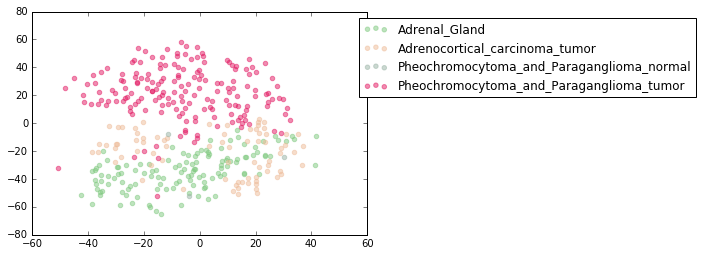

In [8]:
files = split_TCGA_tumor_normal('adrenal')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2,1))

In [111]:
determine_distance(X, label, files)

Distance for: Adrenal_Gland Adrenocortical_carcinoma_tumor: 5.16009781969 
Distance for: Adrenal_Gland Pheochromocytoma_and_Paraganglioma_tumor: 37.3896532208 
Distance for: Adrenocortical_carcinoma_tumor Pheochromocytoma_and_Paraganglioma_normal: 14.9473087498 
Distance for: Adrenocortical_carcinoma_tumor Pheochromocytoma_and_Paraganglioma_tumor: 35.792013306 
Distance for: Pheochromocytoma_and_Paraganglioma_normal Pheochromocytoma_and_Paraganglioma_tumor: 26.091321727 

Smallest Distance: Adrenal_Gland, Adrenocortical_carcinoma_tumor: 5.16009781969


Conclusion: Adrenal Gland should be compared to Adrenocortical carcinoma, but not to pheochromocytoma / Paraganglioma

# Bladder

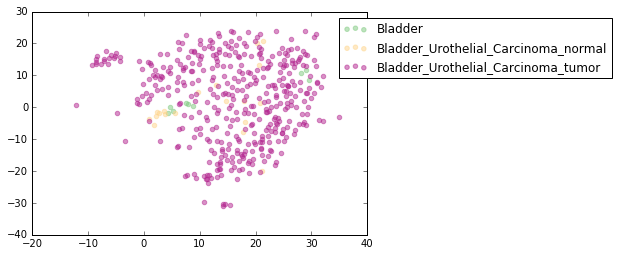

In [112]:
files = split_TCGA_tumor_normal('bladder')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, alpha=.5)

In [113]:
determine_distance(X, label, files)

Distance for: Bladder Bladder_Urothelial_Carcinoma_tumor: 2.02668887843 
Distance for: Bladder_Urothelial_Carcinoma_normal Bladder_Urothelial_Carcinoma_tumor: 4.59242105861 

Smallest Distance: Bladder, Bladder_Urothelial_Carcinoma_tumor: 2.02668887843


Conclusion: Bladder and Bladder Urothelial Carcinoma comparable, but low number of normal samples. **Possible candidate for exclusion.**

# Breast 

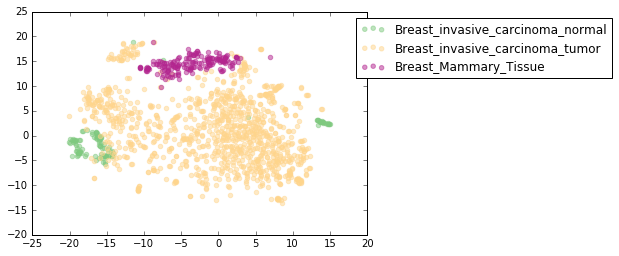

In [114]:
files = split_TCGA_tumor_normal('breast')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [115]:
determine_distance(X, label, files)

Distance for: Breast_invasive_carcinoma_normal Breast_invasive_carcinoma_tumor: 10.5022199445 
Distance for: Breast_invasive_carcinoma_tumor Breast_Mammary_Tissue: 13.6301527451 

Smallest Distance: Breast_invasive_carcinoma_normal, Breast_invasive_carcinoma_tumor: 10.5022199445


Conclusion: Comparable.

# Cervix

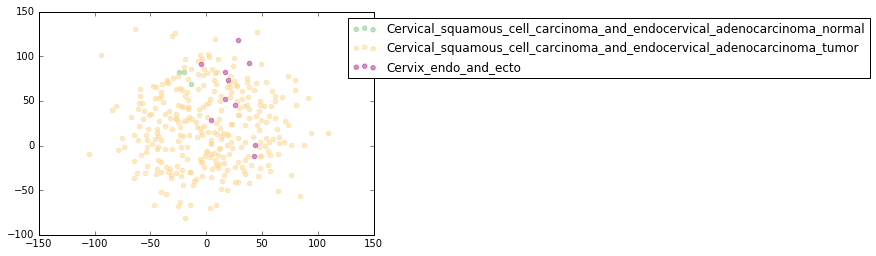

In [11]:
files = split_TCGA_tumor_normal('cervix')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2.5, 1))

In [117]:
determine_distance(X, label, files)

Distance for: Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_normal Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_tumor: 25.4352189647 
Distance for: Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_tumor Cervix_endo_and_ecto: 17.51129185 

Smallest Distance: Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_tumor, Cervix_endo_and_ecto: 17.51129185


Conclusion: Low # of normals. **Possible candidate for exclusions**

# Colon

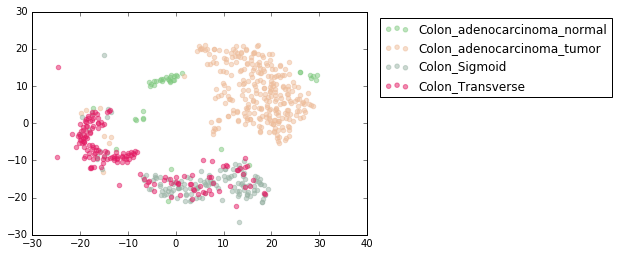

In [118]:
files = split_TCGA_tumor_normal('colon')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [119]:
determine_distance(X, label, files)

Distance for: Colon_adenocarcinoma_normal Colon_adenocarcinoma_tumor: 14.1243678898 
Distance for: Colon_adenocarcinoma_tumor Colon_Sigmoid: 25.9872492326 
Distance for: Colon_adenocarcinoma_tumor Colon_Transverse: 30.5873632395 

Smallest Distance: Colon_adenocarcinoma_normal, Colon_adenocarcinoma_tumor: 14.1243678898


Conclusions: Compare colon adenocarcinoma to colon sigmoid

# Esophagus

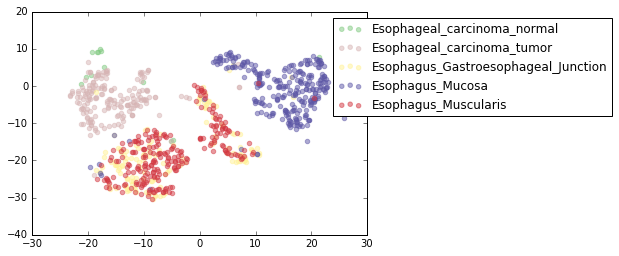

In [120]:
files = split_TCGA_tumor_normal('esophagus')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [121]:
determine_distance(X_mask, label_mask, files)

Distance for: Esophageal_carcinoma_normal Esophageal_carcinoma_tumor: 10.1394950578 
Distance for: Esophageal_carcinoma_tumor Esophagus_Gastroesophageal_Junction: 8.00797270192 
Distance for: Esophageal_carcinoma_tumor Esophagus_Mucosa: 12.3729343474 
Distance for: Esophageal_carcinoma_tumor Esophagus_Muscularis: 4.68647153667 

Smallest Distance: Esophageal_carcinoma_tumor, Esophagus_Muscularis: 4.68647153667


Conclusion: combine junction and muscularis and compare to carcinoma.

# Kidney

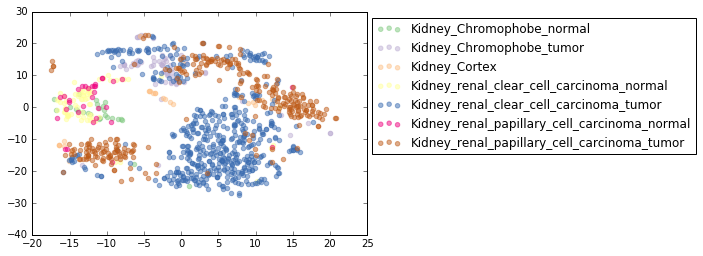

In [122]:
files = split_TCGA_tumor_normal('kidney')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2,1))

In [124]:
determine_distance(X, label, files)

Distance for: Kidney_Chromophobe_normal Kidney_Chromophobe_tumor: 16.2326017258 
Distance for: Kidney_Chromophobe_normal Kidney_renal_clear_cell_carcinoma_tumor: 15.736265798 
Distance for: Kidney_Chromophobe_normal Kidney_renal_papillary_cell_carcinoma_tumor: 14.3503850243 
Distance for: Kidney_Chromophobe_tumor Kidney_Cortex: 11.4424589349 
Distance for: Kidney_Chromophobe_tumor Kidney_renal_clear_cell_carcinoma_normal: 13.7397292349 
Distance for: Kidney_Chromophobe_tumor Kidney_renal_clear_cell_carcinoma_tumor: 19.2051427179 
Distance for: Kidney_Chromophobe_tumor Kidney_renal_papillary_cell_carcinoma_normal: 13.1574223838 
Distance for: Kidney_Chromophobe_tumor Kidney_renal_papillary_cell_carcinoma_tumor: 12.4202630931 
Distance for: Kidney_Cortex Kidney_renal_clear_cell_carcinoma_tumor: 10.0744431132 
Distance for: Kidney_Cortex Kidney_renal_papillary_cell_carcinoma_tumor: 6.53049042352 
Distance for: Kidney_renal_clear_cell_carcinoma_normal Kidney_renal_clear_cell_carcinoma_tumo

Conclusions: Low number of normals. Clear cell and papillary could undergo standard TCGA T/N differential expression. **Candidate for exclusion**.

# Liver

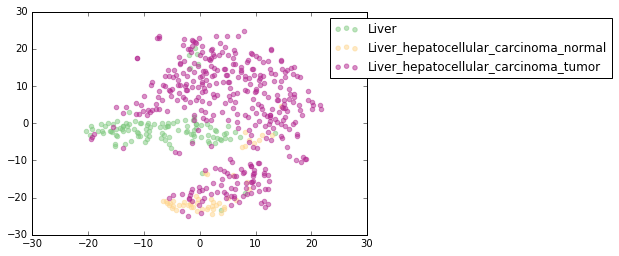

In [125]:
files = split_TCGA_tumor_normal('liver')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [126]:
determine_distance(X, label, files)

Distance for: Liver Liver_hepatocellular_carcinoma_tumor: 12.3798123603 
Distance for: Liver_hepatocellular_carcinoma_normal Liver_hepatocellular_carcinoma_tumor: 21.3203896735 

Smallest Distance: Liver, Liver_hepatocellular_carcinoma_tumor: 12.3798123603


Conclusion: Comparable.

# Lung

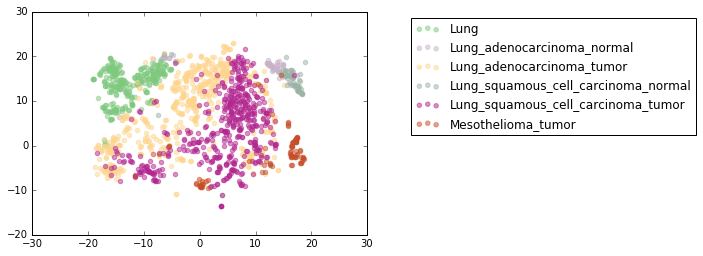

In [127]:
files = split_TCGA_tumor_normal('lung')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2,1))

In [128]:
determine_distance(X, label, files)

Distance for: Lung Lung_adenocarcinoma_tumor: 11.9609693953 
Distance for: Lung Lung_squamous_cell_carcinoma_tumor: 19.1025429178 
Distance for: Lung Mesothelioma_tumor: 28.9709405253 
Distance for: Lung_adenocarcinoma_normal Lung_adenocarcinoma_tumor: 14.7831514602 
Distance for: Lung_adenocarcinoma_normal Lung_squamous_cell_carcinoma_tumor: 14.3512420327 
Distance for: Lung_adenocarcinoma_normal Mesothelioma_tumor: 19.5676869875 
Distance for: Lung_adenocarcinoma_tumor Lung_squamous_cell_carcinoma_normal: 18.3511485345 
Distance for: Lung_adenocarcinoma_tumor Lung_squamous_cell_carcinoma_tumor: 7.14164637506 
Distance for: Lung_adenocarcinoma_tumor Mesothelioma_tumor: 17.0225132105 
Distance for: Lung_squamous_cell_carcinoma_normal Lung_squamous_cell_carcinoma_tumor: 15.1786889898 
Distance for: Lung_squamous_cell_carcinoma_normal Mesothelioma_tumor: 16.7020157048 
Distance for: Lung_squamous_cell_carcinoma_tumor Mesothelioma_tumor: 9.89881781642 

Smallest Distance: Lung_adenocarcin

Conclusion: Lung adenocarcinoma clusters most tightly with GTEx lung tissue, but Mesothelioma and squamous cell are likely directly comparable as well.

# Ovary

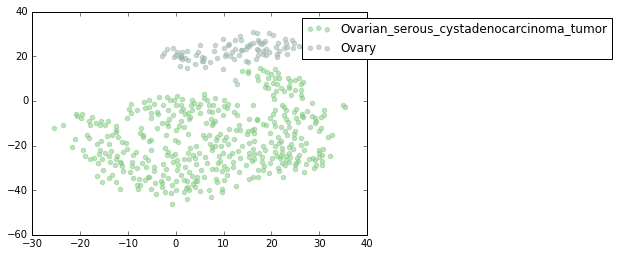

In [129]:
files = split_TCGA_tumor_normal('ovary')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [130]:
determine_distance(X, label, files)

Distance for: Ovarian_serous_cystadenocarcinoma_tumor Ovary: 39.5339643872 

Smallest Distance: Ovarian_serous_cystadenocarcinoma_tumor, Ovary: 39.5339643872


Conclusion: Comparable

# Pancreas

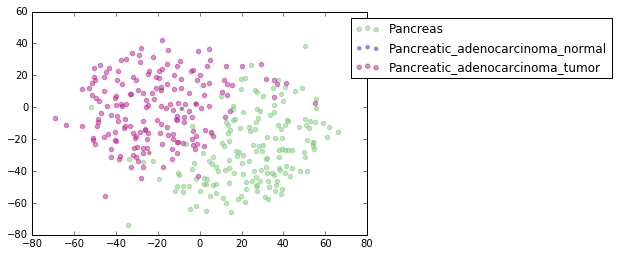

In [131]:
files = split_TCGA_tumor_normal('pancreas')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [132]:
determine_distance(X, label, files)

Distance for: Pancreas Pancreatic_adenocarcinoma_tumor: 52.0454707545 
Distance for: Pancreatic_adenocarcinoma_normal Pancreatic_adenocarcinoma_tumor: 8.20501832676 

Smallest Distance: Pancreatic_adenocarcinoma_normal, Pancreatic_adenocarcinoma_tumor: 8.20501832676


Conslusion: Comparable

# Prostate

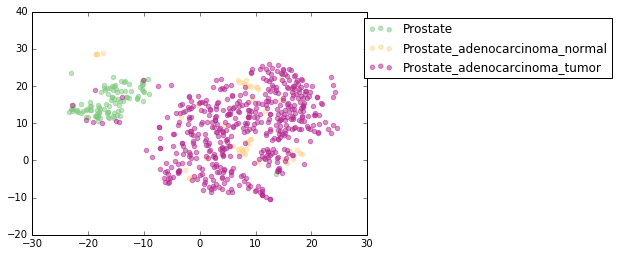

In [133]:
files = split_TCGA_tumor_normal('prostate')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [134]:
determine_distance(X, label, files)

Distance for: Prostate Prostate_adenocarcinoma_tumor: 24.8953922928 
Distance for: Prostate_adenocarcinoma_normal Prostate_adenocarcinoma_tumor: 3.33157227594 

Smallest Distance: Prostate_adenocarcinoma_normal, Prostate_adenocarcinoma_tumor: 3.33157227594


Conclusion: Comparable

# Skin

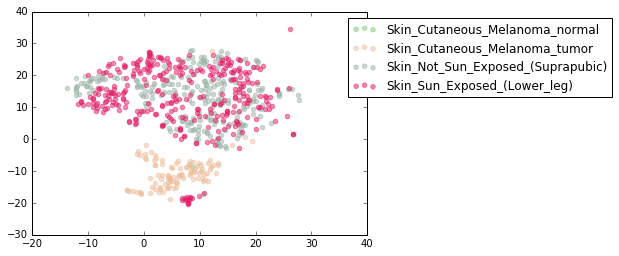

In [135]:
files = split_TCGA_tumor_normal('skin')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [136]:
determine_distance(X, label, files)

Distance for: Skin_Cutaneous_Melanoma_normal Skin_Cutaneous_Melanoma_tumor: 3.01027119826 
Distance for: Skin_Cutaneous_Melanoma_tumor Skin_Not_Sun_Exposed_(Suprapubic): 23.5925011581 
Distance for: Skin_Cutaneous_Melanoma_tumor Skin_Sun_Exposed_(Lower_leg): 23.3062678378 

Smallest Distance: Skin_Cutaneous_Melanoma_normal, Skin_Cutaneous_Melanoma_tumor: 3.01027119826


Conclusion: combine GTEx skin groups and compare to Melanoma.

# Stomach

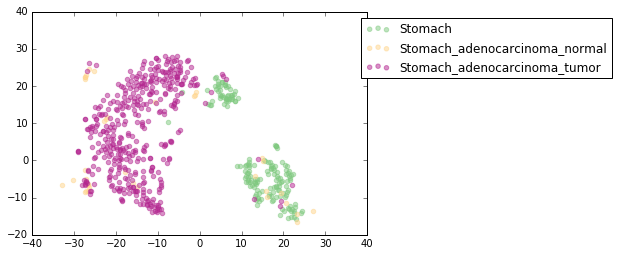

In [137]:
files = split_TCGA_tumor_normal('stomach')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [138]:
determine_distance(X, label, files)

Distance for: Stomach Stomach_adenocarcinoma_tumor: 29.0226906537 
Distance for: Stomach_adenocarcinoma_normal Stomach_adenocarcinoma_tumor: 7.38317360301 

Smallest Distance: Stomach_adenocarcinoma_normal, Stomach_adenocarcinoma_tumor: 7.38317360301


Conclusion: comparable.

# Testis

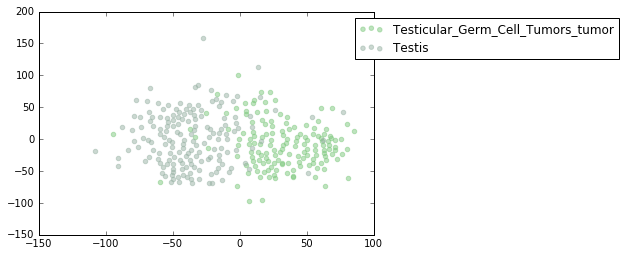

In [139]:
files = split_TCGA_tumor_normal('testis')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [140]:
determine_distance(X, label, files)

Distance for: Testicular_Germ_Cell_Tumors_tumor Testis: 68.2514823552 

Smallest Distance: Testicular_Germ_Cell_Tumors_tumor, Testis: 68.2514823552


# Thyroid

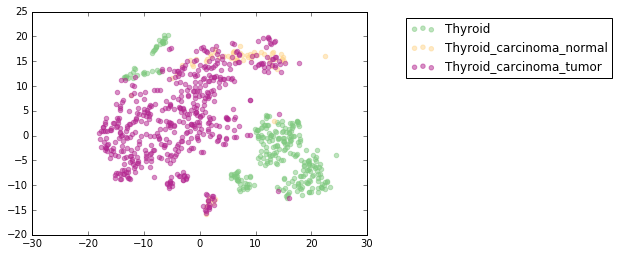

In [141]:
files = split_TCGA_tumor_normal('thyroid')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label)

In [142]:
determine_distance(X, label, files)

Distance for: Thyroid Thyroid_carcinoma_tumor: 15.9155223798 
Distance for: Thyroid_carcinoma_normal Thyroid_carcinoma_tumor: 12.4706191315 

Smallest Distance: Thyroid_carcinoma_normal, Thyroid_carcinoma_tumor: 12.4706191315


# Uterus

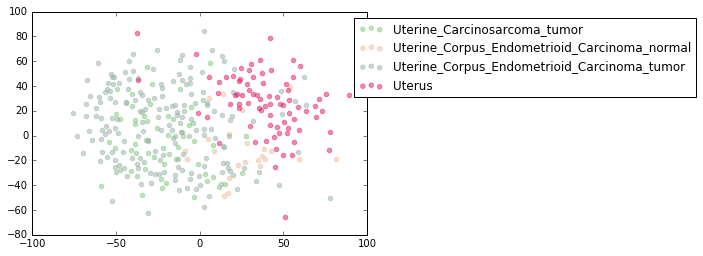

In [10]:
files = split_TCGA_tumor_normal('uterus')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2,1))

In [144]:
determine_distance(X, label, files)

Distance for: Uterine_Carcinosarcoma_tumor Uterine_Corpus_Endometrioid_Carcinoma_normal: 11.9569517877 
Distance for: Uterine_Carcinosarcoma_tumor Uterine_Corpus_Endometrioid_Carcinoma_tumor: 30.0136742964 
Distance for: Uterine_Carcinosarcoma_tumor Uterus: 48.0647151287 
Distance for: Uterine_Corpus_Endometrioid_Carcinoma_normal Uterine_Corpus_Endometrioid_Carcinoma_tumor: 28.7531478629 
Distance for: Uterine_Corpus_Endometrioid_Carcinoma_tumor Uterus: 63.7691515103 

Smallest Distance: Uterine_Carcinosarcoma_tumor, Uterine_Corpus_Endometrioid_Carcinoma_normal: 11.9569517877


# Brain

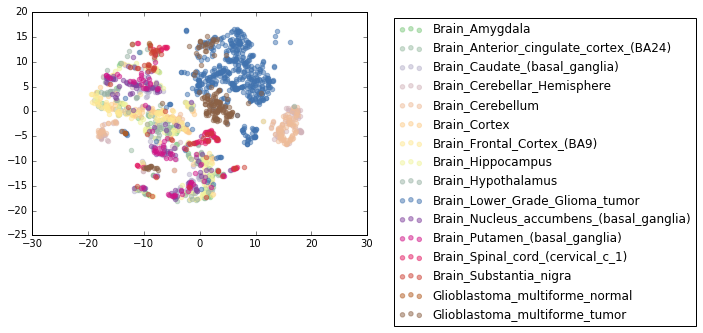

In [13]:
files = split_TCGA_tumor_normal('brain')
vector, label = create_classification_vector(files)
df = create_combined_df(files, pc_genes)
X = run_TSNE(df)
plot_dimensionality_reduction(X, files, label, bbox=(2,1))

In [146]:
determine_distance(X, label, files)

Distance for: Brain_Amygdala Brain_Lower_Grade_Glioma_tumor: 13.6290723608 
Distance for: Brain_Amygdala Glioblastoma_multiforme_tumor: 12.9788126798 
Distance for: Brain_Anterior_cingulate_cortex_(BA24) Brain_Lower_Grade_Glioma_tumor: 11.694043814 
Distance for: Brain_Anterior_cingulate_cortex_(BA24) Glioblastoma_multiforme_tumor: 13.2349741277 
Distance for: Brain_Caudate_(basal_ganglia) Brain_Lower_Grade_Glioma_tumor: 11.2175151978 
Distance for: Brain_Caudate_(basal_ganglia) Glioblastoma_multiforme_tumor: 9.43787663782 
Distance for: Brain_Cerebellar_Hemisphere Brain_Lower_Grade_Glioma_tumor: 8.47497516147 
Distance for: Brain_Cerebellar_Hemisphere Glioblastoma_multiforme_tumor: 15.5160145675 
Distance for: Brain_Cerebellum Brain_Lower_Grade_Glioma_tumor: 9.84295098504 
Distance for: Brain_Cerebellum Glioblastoma_multiforme_tumor: 17.3973672356 
Distance for: Brain_Cortex Brain_Lower_Grade_Glioma_tumor: 11.7410309879 
Distance for: Brain_Cortex Glioblastoma_multiforme_tumor: 15.182

### Reproducibility

Below is the directory structure used to replicate the above plots. 

```
├── adrenal
│   ├── Adrenal_Gland.tsv
│   ├── Adrenocortical_carcinoma.tsv
│   ├── Adrenocortical_carcinoma_tumor.tsv
│   ├── Pheochromocytoma_and_Paraganglioma.tsv
│   ├── Pheochromocytoma_and_Paraganglioma_normal.tsv
│   └── Pheochromocytoma_and_Paraganglioma_tumor.tsv
├── bladder
│   ├── Bladder.tsv
│   ├── Bladder_Urothelial_Carcinoma.tsv
│   ├── Bladder_Urothelial_Carcinoma_normal.tsv
│   └── Bladder_Urothelial_Carcinoma_tumor.tsv
├── brain
│   ├── Brain_Amygdala.tsv
│   ├── Brain_Anterior_cingulate_cortex_(BA24).tsv
│   ├── Brain_Caudate_(basal_ganglia).tsv
│   ├── Brain_Cerebellar_Hemisphere.tsv
│   ├── Brain_Cerebellum.tsv
│   ├── Brain_Cortex.tsv
│   ├── Brain_Frontal_Cortex_(BA9).tsv
│   ├── Brain_Hippocampus.tsv
│   ├── Brain_Hypothalamus.tsv
│   ├── Brain_Lower_Grade_Glioma.tsv
│   ├── Brain_Lower_Grade_Glioma_tumor.tsv
│   ├── Brain_Nucleus_accumbens_(basal_ganglia).tsv
│   ├── Brain_Putamen_(basal_ganglia).tsv
│   ├── Brain_Spinal_cord_(cervical_c_1).tsv
│   ├── Brain_Substantia_nigra.tsv
│   ├── Glioblastoma_multiforme.tsv
│   ├── Glioblastoma_multiforme_normal.tsv
│   └── Glioblastoma_multiforme_tumor.tsv
├── breast
│   ├── Breast_Mammary_Tissue.tsv
│   ├── Breast_invasive_carcinoma.tsv
│   ├── Breast_invasive_carcinoma_normal.tsv
│   └── Breast_invasive_carcinoma_tumor.tsv
├── cervix
│   ├── Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma.tsv
│   ├── Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_normal.tsv
│   ├── Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma_tumor.tsv
│   └── Cervix_endo_and_ecto.tsv
├── colon
│   ├── Colon_Sigmoid.tsv
│   ├── Colon_Transverse.tsv
│   ├── Colon_adenocarcinoma.tsv
│   ├── Colon_adenocarcinoma_normal.tsv
│   └── Colon_adenocarcinoma_tumor.tsv
├── esophagus
│   ├── Esophageal_carcinoma.tsv
│   ├── Esophageal_carcinoma_normal.tsv
│   ├── Esophageal_carcinoma_tumor.tsv
│   ├── Esophagus_Gastroesophageal_Junction.tsv
│   ├── Esophagus_Mucosa.tsv
│   └── Esophagus_Muscularis.tsv
├── gencode.v23.annotation.gtf
├── kidney
│   ├── Kidney_Chromophobe.tsv
│   ├── Kidney_Chromophobe_normal.tsv
│   ├── Kidney_Chromophobe_tumor.tsv
│   ├── Kidney_Cortex.tsv
│   ├── Kidney_renal_clear_cell_carcinoma.tsv
│   ├── Kidney_renal_clear_cell_carcinoma_normal.tsv
│   ├── Kidney_renal_clear_cell_carcinoma_tumor.tsv
│   ├── Kidney_renal_papillary_cell_carcinoma.tsv
│   ├── Kidney_renal_papillary_cell_carcinoma_normal.tsv
│   └── Kidney_renal_papillary_cell_carcinoma_tumor.tsv
├── liver
│   ├── Liver.tsv
│   ├── Liver_hepatocellular_carcinoma.tsv
│   ├── Liver_hepatocellular_carcinoma_normal.tsv
│   └── Liver_hepatocellular_carcinoma_tumor.tsv
├── lung
│   ├── Lung.tsv
│   ├── Lung_adenocarcinoma.tsv
│   ├── Lung_adenocarcinoma_normal.tsv
│   ├── Lung_adenocarcinoma_tumor.tsv
│   ├── Lung_squamous_cell_carcinoma.tsv
│   ├── Lung_squamous_cell_carcinoma_normal.tsv
│   ├── Lung_squamous_cell_carcinoma_tumor.tsv
│   ├── Mesothelioma.tsv
│   └── Mesothelioma_tumor.tsv
├── ovary
│   ├── Ovarian_serous_cystadenocarcinoma.tsv
│   ├── Ovarian_serous_cystadenocarcinoma_tumor.tsv
│   └── Ovary.tsv
├── pancreas
│   ├── Pancreas.tsv
│   ├── Pancreatic_adenocarcinoma.tsv
│   ├── Pancreatic_adenocarcinoma_normal.tsv
│   └── Pancreatic_adenocarcinoma_tumor.tsv
├── prostate
│   ├── Prostate.tsv
│   ├── Prostate_adenocarcinoma.tsv
│   ├── Prostate_adenocarcinoma_normal.tsv
│   └── Prostate_adenocarcinoma_tumor.tsv
├── skin
│   ├── Skin_Cutaneous_Melanoma.tsv
│   ├── Skin_Cutaneous_Melanoma_normal.tsv
│   ├── Skin_Cutaneous_Melanoma_tumor.tsv
│   ├── Skin_Not_Sun_Exposed_(Suprapubic).tsv
│   └── Skin_Sun_Exposed_(Lower_leg).tsv
├── stomach
│   ├── Stomach.tsv
│   ├── Stomach_adenocarcinoma.tsv
│   ├── Stomach_adenocarcinoma_normal.tsv
│   └── Stomach_adenocarcinoma_tumor.tsv
├── testis
│   ├── Testicular_Germ_Cell_Tumors.tsv
│   ├── Testicular_Germ_Cell_Tumors_tumor.tsv
│   └── Testis.tsv
├── thyroid
│   ├── Thyroid.tsv
│   ├── Thyroid_carcinoma.tsv
│   ├── Thyroid_carcinoma_normal.tsv
│   └── Thyroid_carcinoma_tumor.tsv
└── uterus
    ├── Uterine_Carcinosarcoma.tsv
    ├── Uterine_Carcinosarcoma_tumor.tsv
    ├── Uterine_Corpus_Endometrioid_Carcinoma.tsv
    ├── Uterine_Corpus_Endometrioid_Carcinoma_normal.tsv
    ├── Uterine_Corpus_Endometrioid_Carcinoma_tumor.tsv
    └── Uterus.tsv
```
